In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans



import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



In [54]:
data_set_conaminantes = pd.read_csv('../../data/processed/normalizados/Dataset_MinMax.csv',sep=';', thousands=None, decimal=',')
data_set_conaminantes['fecha'] = pd.to_datetime(data_set_conaminantes['fecha'])

c:\Users\benja\Documents\Particulas_contaminantes_chillan\env\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


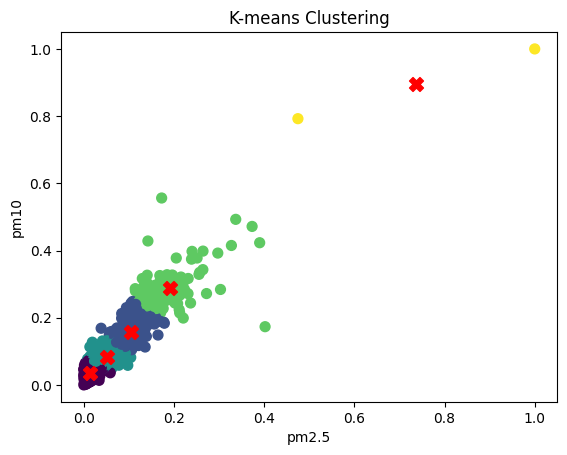

In [55]:

# Preparar los datos para la imputación
X = data_set_conaminantes[['pm2.5', 'pm10']].values

# agregar la variable humedad empeora el agrupamiento
# X = data_set_conaminantes[['pm2.5', 'pm10','humedad']].values

# valores entre 3-6 clusters se debe ver
kmeans = KMeans(n_clusters=5) 


kmeans.fit(X)

# Obtener las etiquetas de los clusters y los centroides
labels = kmeans.predict(X)
centroids = kmeans.cluster_centers_
 

plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')


plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100, marker='X')


plt.title('K-means Clustering')
plt.xlabel('pm2.5')
plt.ylabel('pm10')
plt.show()

In [56]:
# Asumiendo que 'labels' son tus etiquetas de clúster
data_set_conaminantes['cluster_label'] = labels


In [57]:
data_set_conaminantes['cluster_label'] = data_set_conaminantes['cluster_label'].astype('category')

# Realizar one-hot encoding

data_set_conaminantes = pd.get_dummies(data_set_conaminantes, columns=['cluster_label'], prefix=['cluster'])

# Obtener las columnas que fueron generadas por get_dummies
cluster_columns = [col for col in data_set_conaminantes if col.startswith('cluster')]

# Convertir solo las columnas booleanas a enteros
data_set_conaminantes[cluster_columns] = data_set_conaminantes[cluster_columns].astype(int)


In [58]:
# Crear columnas para cada estación y llenar con 0
data_set_conaminantes['es_Primavera'] = 0
data_set_conaminantes['es_Verano'] = 0
data_set_conaminantes['es_Otoño'] = 0
data_set_conaminantes['es_Invierno'] = 0



def get_estacion(fecha):
    dia = fecha.timetuple().tm_yday
    
    # Definiendo los días del año para los cambios de estación en el hemisferio sur
    verano = 355  # ~21 de diciembre
    otoño = 80     # ~21 de marzo
    invierno = 172  # ~21 de junio
    primavera = 264  # ~21 de septiembre
    
    # Determinar la estación basada en el día del año
    if verano <= dia or dia < otoño:
        return 'Verano'
    elif otoño <= dia < invierno:
        return 'Otoño'
    elif invierno <= dia < primavera:
        return 'Invierno'
    else:
        return 'Primavera'



# Actualizar las columnas de estación basado en la fecha
for index, row in data_set_conaminantes.iterrows():
    estacion = get_estacion(row['fecha'])
    
    if estacion == 'Primavera':
        data_set_conaminantes.at[index, 'es_Primavera'] = 1
    elif estacion == 'Verano':
        data_set_conaminantes.at[index, 'es_Verano'] = 1
    elif estacion == 'Otoño':
        data_set_conaminantes.at[index, 'es_Otoño'] = 1
    elif estacion == 'Invierno':
        data_set_conaminantes.at[index, 'es_Invierno'] = 1

In [59]:
data_set_conaminantes.columns

Index(['fecha', 'pm2.5', 'pm10', 'humedad', 'puntoRocio', 'temperatura',
       'dd_Valor', 'ff_Valor', 'cluster_0', 'cluster_1', 'cluster_2',
       'cluster_3', 'cluster_4', 'es_Primavera', 'es_Verano', 'es_Otoño',
       'es_Invierno'],
      dtype='object')

In [60]:
data_set_conaminantes = data_set_conaminantes.drop(['fecha'],axis=1)
data_set_conaminantes = data_set_conaminantes.drop(['dd_Valor'],axis=1)


X = data_set_conaminantes[['humedad', 
                           'puntoRocio', 
                           'temperatura', 
                           'ff_Valor', 
                           'es_Primavera', 
                           'es_Verano', 
                           'es_Otoño', 
                           'es_Invierno',
                           'cluster_0', 
                           'cluster_1', 
                           'cluster_2', 
                           'cluster_3', 
                           'cluster_4'
                           ]]

 
y = data_set_conaminantes[['pm10', 'pm2.5']]


# dividir datos en entrenamiento (80%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# luego ese 20 porciento dividirlo en 2 para hacer validacion y test
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [61]:

model = Sequential([
    Dense(13, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(2, activation='linear')
])


In [62]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001), 
    loss='mean_squared_error',
)

historial = model.fit(X_train, y_train, epochs=50, verbose=0)



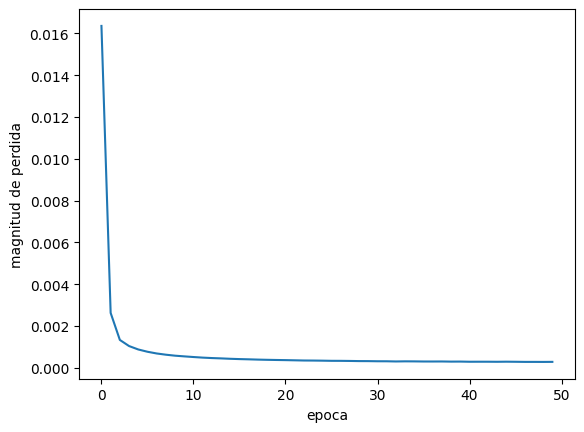

In [63]:
plt.xlabel('epoca')
plt.ylabel('magnitud de perdida')
plt.plot(historial.history["loss"])

In [64]:
y_pred = model.predict(X_temp)


24/24 [==============================] - 0s 805us/step


In [65]:
# Calcular métricas
mae = mean_absolute_error(y_temp, y_pred)
mse = mean_squared_error(y_temp, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_temp, y_pred)

# Mostrar métricas
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

MAE: 0.011680202642648175
MSE: 0.0005585529860259394
RMSE: 0.023633725606132
R^2: 0.8202571656196542


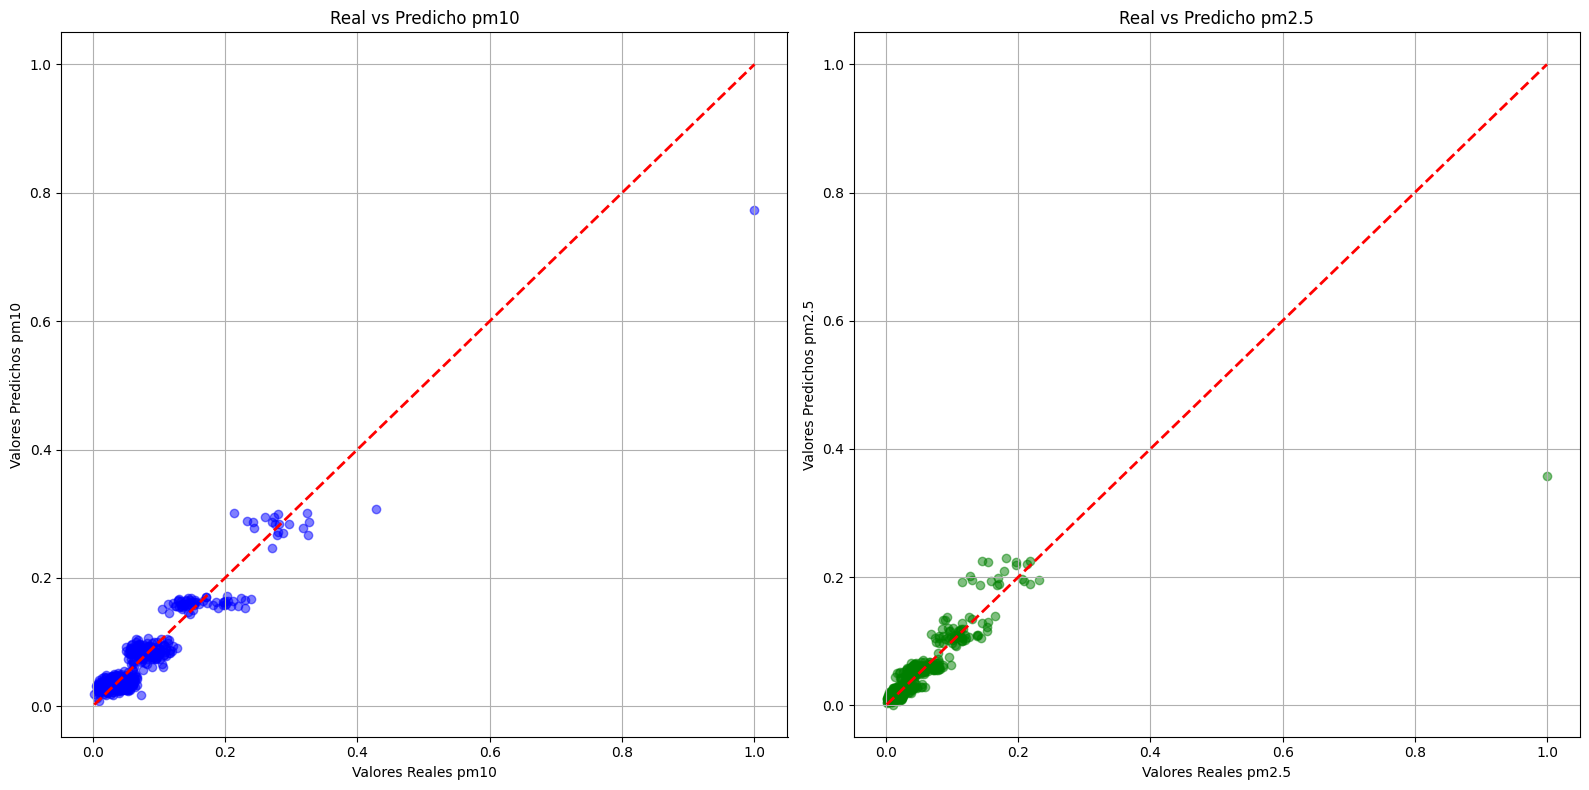

In [66]:
y_true_pm10 = y_temp['pm10']
y_true_pm25 = y_temp['pm2.5']

y_pred_pm10 = y_pred[:, 0]
y_pred_pm25 = y_pred[:, 1]

fig, axs = plt.subplots(1, 2, figsize=(16, 8))  # 1 fila, 2 columnas de gráficos

# grafico para pm10
axs[0].scatter(y_true_pm10, y_pred_pm10, alpha=0.5, color='blue')
axs[0].plot([min(y_true_pm10), max(y_true_pm10)], 
           [min(y_true_pm10), max(y_true_pm10)], 
           color='red', linestyle='--', lw=2)
axs[0].set_title('Real vs Predicho pm10')
axs[0].set_xlabel('Valores Reales pm10')
axs[0].set_ylabel('Valores Predichos pm10')
axs[0].grid(True)





# grafico para pm2.5
axs[1].scatter(y_true_pm25, y_pred_pm25, alpha=0.5, color='green')
axs[1].plot([min(y_true_pm25), max(y_true_pm25)], 
           [min(y_true_pm25), max(y_true_pm25)], 
           color='red', linestyle='--', lw=2)
axs[1].set_title('Real vs Predicho pm2.5')
axs[1].set_xlabel('Valores Reales pm2.5')
axs[1].set_ylabel('Valores Predichos pm2.5')
axs[1].grid(True)

# Ajustar el espacio entre los gráficos
plt.tight_layout()
plt.show()